![Imgur](https://i.imgur.com/Q6G8Eqi.png)

**How to Enable GPU Acceleration:**
* On the right side of the notebook, you'll see a sidebar with various options.
* Look for the "Accelerator" section.
* In the dropdown menu, select "GPU".

## ①　Introduction
Fashion-MNIST dataset is to serve as a more challenging replacement for the classic MNIST dataset for benchmarking machine learning algorithms. The Fashion-MNIST dataset was created by Zalando, an e-commerce company, and consists of a collection of 70,000 grayscale images, each 28x28 pixels, divided into 60,000 training images and 10,000 test images. Each image is associated with one of 10 classes representing different types of clothing and accessories, such as T-shirts/tops, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots.

🎯　Your goal is to **classify the types of clothing** with one of 10 classes.

Basically, your main job is to make a better neural network architecture in part ⑥.

You are free to add/remove sections and made any modification to this notebook. Only your final submission will be graded. This notebook will not be graded.

## ②　Setting Up the Environment
These are some of the libraries used in the lecture.

In [1]:
# Basic Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import random
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing
from sklearn.preprocessing   import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Model Validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics         import accuracy_score, mean_squared_error, r2_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Deep learning
!pip install scikeras --quiet
import scikeras
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

## ③　Loading (Training) Dataset

In [2]:
# Load the train dataset
train_url = "/kaggle/input/classification-of-clothing-and-accessories/train.csv"
df_train = pd.read_csv(train_url, index_col='ID')

target_col = 'label'
df_train

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
ID,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
2,0,0,0,0,0,1,0,0,0,0,...,114,130,76,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,22,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,3
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
59998,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,3


## ④　Preprocessing

In [3]:
# Set training set and label
x_train = df_train.drop(columns='label')
y_train = df_train['label']

# Reshaping x_train into 2D and normalize
x_train = x_train.values.reshape((-1, 28, 28, 1)).astype('float32') / 255.0
y_train = y_train.values

# One-hot encoding of labels
num_classes = 10
y_train = np.eye(num_classes)[y_train.reshape(-1)]

## ⑤　Exploratory Data Analysis
In the Fashion-MNIST dataset, each class label from 0 to 9 corresponds to a specific type of clothing item. Here's the list describing what each label represents:

0 = **T-shirt/top**: Typical short-sleeved, casual tops.

1 = **Trouser**: Long pants typically worn for formal occasions or office settings.

2 = **Pullover**: A type of sweater or knitted top that you pull over your head.

3 = **Dress**: A garment typically extending from the shoulders to below the hips, often worn by women or girls.

4 = **Coat**: An outer garment worn outdoors for warmth or as fashion, typically extending below the hips.

5 = **Sandal**: Open type of footwear, consisting of a sole held to the wearer's foot by straps.

6 = **Shirt**: A garment with a collar, sleeves with cuffs, and a full vertical opening with buttons or snaps.

7 = **Sneaker**: A soft shoe with a rubber sole worn for sports or casual occasions.

8 = **Bag**: Various types of handbags, backpacks, or purses.

9 = **Ankle boot**: A boot covering the foot and the ankle and extending up the leg, typically to just above the ankle.

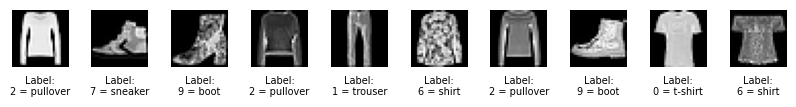

In [4]:
classes = np.array(['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
                    'sneaker', 'bag', 'boot'])

n_to_show = 10
indices = np.random.choice(range(len(x_train)), n_to_show)
fig = plt.figure(figsize=(10, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_train[idx].reshape(28, 28)
    label_index = np.argmax(y_train[idx])  # Get the index of the highest probability
    label = classes[label_index]  # Map the index to the corresponding class name
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.5, f'Label:\n{label_index} = {label}', fontsize=7, ha='center', transform=ax.transAxes)
    ax.imshow(img, cmap='gray')  # Display in grayscale

plt.show()

## ⑥　Training the Neural Network

This includes hyperparameter tuning.

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Flatten, Dense, Conv2D, ReLU, MaxPooling2D
from keras.optimizers import SGD
from keras.layers import Activation, GlobalAveragePooling2D

def create_model(learning_rate=0.01, batch_size=32):
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', input_shape=(28, 28, 1)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        GlobalAveragePooling2D(),
        
        Dense(512),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        
        Dense(256),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        
        Dense(10, activation='softmax')
    ])
    
    # Change optimizer to SGD with a specific learning rate
    optimizer = SGD(learning_rate=learning_rate)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Making the Model
clf = KerasClassifier(model=create_model, epochs=10, verbose=1)

# Training the model on the entire training data
clf.fit(x_train, y_train)

Epoch 1/10
1875/1875 [==============================] - 26s 9ms/step - loss: 0.4722 - accuracy: 0.8342
Epoch 2/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.2933 - accuracy: 0.8985
Epoch 3/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.2468 - accuracy: 0.9125
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2196 - accuracy: 0.9234
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1955 - accuracy: 0.9312
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1739 - accuracy: 0.9376
Epoch 7/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1525 - accuracy: 0.9444
Epoch 8/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1334 - accuracy: 0.9521
Epoch 9/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1143 - accuracy: 0.9590
Epoch 10/10
1875/1875 [==============================] - 17s 9ms/step - l

KerasClassifier(
	model=<function create_model at 0x78143be40af0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	class_weight=None
)

## ⑦　(Optional) Hyperparameter Tuning 


In [6]:
# # Define the hyperparameter grid
# param_grid = {
#     'optimizer__learning_rate': [0.001, 0.01, 0.1],
#     'batch_size': [32, 64, 128]
# }

# # Use GridSearchCV to search for the best hyperparameters
# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3)
# grid_result = grid_search.fit(x_train, y_train)

# # Print the best hyperparameters
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

## ⑧　Making Prediction

In [7]:
# Load the train dataset
test_url = "/kaggle/input/classification-of-clothing-and-accessories/test.csv"
df_test = pd.read_csv(test_url, index_col='ID')

# Preprocess the test set
x_test = df_test.values.reshape((-1, 28, 28, 1)).astype('float32') / 255.0

# Making prediction
y_pred = clf.predict(x_test)

313/313 [==============================] - 1s 4ms/step


## ⑨　Submitting the Prediction

In [8]:
# Convert one-hot encoded predictions to class labels
y_pred = np.argmax(y_pred, axis=1)

# Make DataFrame for Submission
submission = pd.DataFrame(y_pred, index=df_test.index, columns=[target_col])

# Make a CSV file for Submission
submission.to_csv('submission.csv')

submission

,label
ID,
60001,7
60002,5
60003,4
60004,5
60005,8
...,...
69996,3
69997,7
69998,0
